In [1]:
%matplotlib widget

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt


# Libraries
import rospy
import time
import os
import tf
import sys
import actionlib
import numpy as np
# import jupyros as jr


from IPython.display import clear_output
from IPython.display import display
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
from ipywidgets import interact, interactive
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from tf.transformations import quaternion_matrix


# Messages
from std_msgs.msg import String
from geometry_msgs.msg import Twist, Vector3
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from std_msgs.msg import Float32, Int32

#from jupyros import ros3d


# Custom services
from final_assignment.srv import GoalCoordinates
from std_srvs.srv import Empty

reached_points = []

In [2]:
class Visualiser:
    def __init__(self, limit_on_x, fig_title):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'bo')
        self.x_data, self.y_data = [] , []
        self.x_limits=limit_on_x
        self.ax.set_title(fig_title)
        
    def plot_init(self):
        self.ax.set_xlim(-self.x_limits, self.x_limits)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def odom_clbk(self, msg):
        self.y_data.append(msg.pose.pose.position.y) #try the append on the scanner
        self.x_data.append(msg.pose.pose.position.x)
       
    def laser_clbk(self, msg):
        self.x_data = msg.ranges
        self.y_data = msg.intensities        
   
    def refresh_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln
    



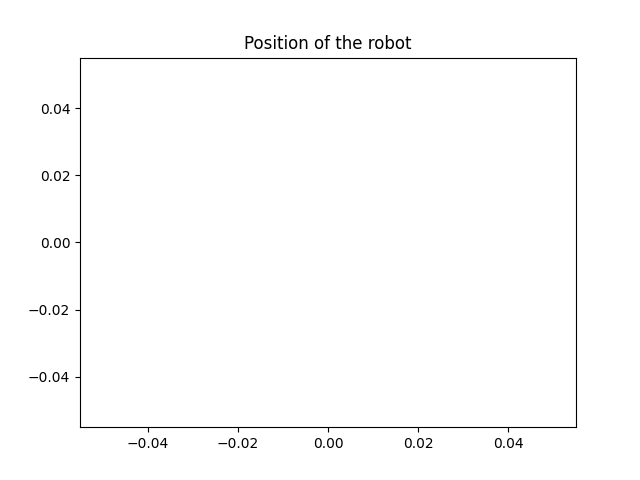

In [3]:
vis_odom = Visualiser(10, 'Position of the robot')
sub_odom = rospy.Subscriber('/odom', Odometry, vis_odom.odom_clbk)
ani1 = FuncAnimation(vis_odom.fig, vis_odom.refresh_plot, init_func=vis_odom.plot_init)
plt.show(block=True)



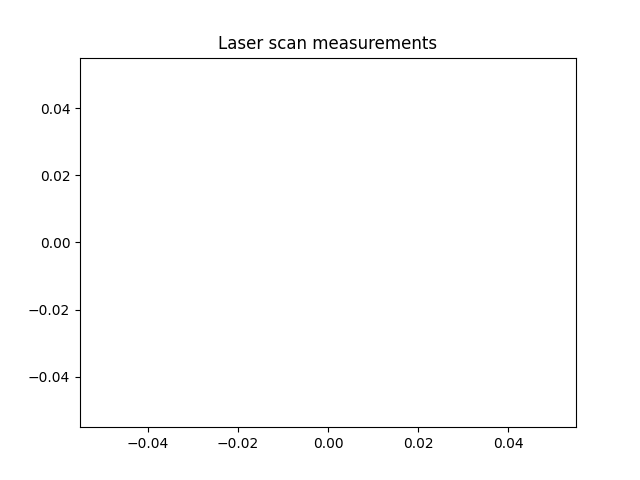

In [4]:
vis_scan = Visualiser(100, 'Laser scan measurements')
sub_scan = rospy.Subscriber('/scan', LaserScan, vis_scan.laser_clbk)
ani2 = FuncAnimation(vis_scan.fig, vis_scan.refresh_plot, init_func=vis_scan.plot_init)
plt.show(block=True)

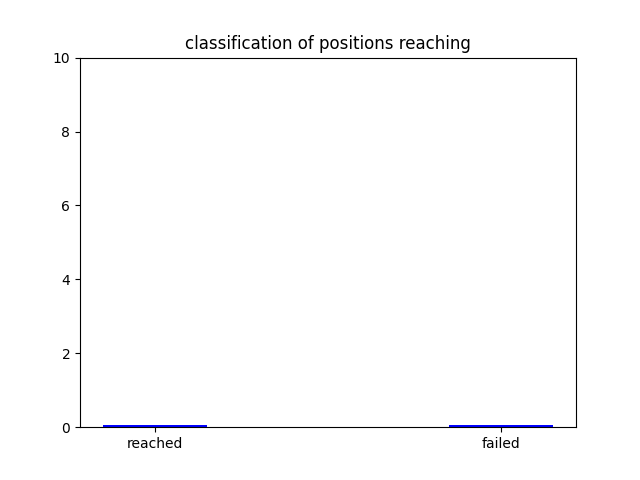

In [5]:
class Analysis:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.y_data = [0.05,0.05] 
        self.labels = ['reached', 'failed'] 
        self.bar = self.ax.bar(self.labels, self.y_data, color = 'b', width = 0.3)
        self.ax.set_ylim(top = 10)
        self.ax.set_title('classification of positions reaching')
    
    def objective_clbk(self, msg):
        if msg.data == 1:
            self.y_data[0]+=1
        else :
            self.y_data[1]+=1
            
    def animate(self, frame):
        index = self.y_data[frame]
        self.bar[frame].set_height(index)
        
        
        
analysis= Analysis()
sub_success = rospy.Subscriber('/goal_reached', Int32, analysis.objective_clbk)
ani3 = FuncAnimation(analysis.fig, analysis.animate, frames=2)
plt.show(block=True)

In [6]:
# rospy.init_node('user_interface')

print('Assignment 3: ROS Mobile Robots Simulator! \n')
print('Hello! Please select between the different modalities to decide the robot driving mode: ')

b1 = Button(description = 'Autonomus Driving Experience',
           layout = Layout(width = 'auto', align = "center", grid_area = 'b1'),
           style = ButtonStyle(button_color = 'lightblue'))

b2 = Button(description = 'Manual Driving Experience',
           layout = Layout(width = 'auto', grid_area = 'b2'),
           style = ButtonStyle(button_color = 'lightblue'))

b3 = Button(description = 'Reset Position',
            layout = Layout(width = 'auto', grid_area = 'b3'),
            button_style='warning')

b4 = Button(description = 'Kill program',
            layout = Layout(width = 'auto', grid_area = 'b4'),
            button_style='danger')

main_gui = GridBox(children = [b1, b2, b3, b4],
                layout = Layout(
                           width = '100%',
                           grid_template_rows = 'auto auto auto',
                           grid_template_columns = '50% 50%',
                           grid_template_areas = '''
                                                "b1 b2"
                                                "b3 b4"
                                                 ''')
)


# if we are in automoatic driving experience (new cell??)

# boxes for entering the coordinate of the taget to reach
x_goal = widgets.FloatText(
                    value=7.5,
                    description='Goal x-coordinate: ',
                    disabled=False
)

y_goal = widgets.FloatText(
                    value=7.5,
                    description='Goal y-coordinate: ',
                    disabled=False
)

bstart = widgets.Button(description="Start Autonomous Navigation")
bcanc  = widgets.Button(description="Back to Main GUI")


# if we are in manual driving experience (new cell??)
set_velocity = widgets.FloatSlider(value=1,
                                   min=0, 
                                   max=3, 
                                   step=0.1, 
                                   description='Robot velocity: ',
                                   disabled=False,
                                   orientation='horizontal')

#console buttons for robot control manual
b_up = Button(description = 'UP',
              layout = Layout(grid_area = 'b_UP'))

b_left = Button(description = 'LEFT',
                layout = Layout(grid_area = 'b_LEFT'))

b_stop = Button(description = 'STOP',
                layout = Layout(grid_area = 'b_STOP'))

b_right = Button(description = 'RIGHT',
            layout = Layout(grid_area = 'b_RIGHT'))

b_down = Button(description = 'DOWN',
                layout = Layout(grid_area = 'b_DOWN'))


man_drive_key = GridBox(children=[b_up, b_left, b_stop, b_right, b_down],
                        layout=Layout(width='50%', grid_template_rows='auto auto',
                        grid_template_columns='33% 33% 33% 33%',
                        grid_template_areas='''
                                            " . b_UP . "
                                            "b_LEFT b_STOP b_RIGHT "
                                            " . b_DOWN . "
                                            ''')
)

#checkbox widget for activate/deactivate the collision avoidance option during the manual navigation of the robot
assistance = widgets.Checkbox(value=False,
                               description='Assisted manual experience, collision avoidance',
                               disabled=False,
                               indent=False
)

#create an output cell
output = widgets.Output()

#display both button and output cell display main menu of the GUI
display(main_gui, output)


#listener for driving choice
b1.on_click(autonomous_drive)
b2.on_click(manual_drive)
b3.on_click(reset_position)
b4.on_click(kill_all)

Assignment 3: ROS Mobile Robots Simulator! 

Hello! Please select between the different modalities to decide the robot driving mode: 


GridBox(children=(Button(description='Autonomus Driving Experience', layout=Layout(grid_area='b1', width='auto…

Output()

FloatSlider(value=1.0, description='Robot velocity: ', max=3.0)

GridBox(children=(Button(description='UP', layout=Layout(grid_area='b_UP'), style=ButtonStyle()), Button(descr…

Checkbox(value=False, description='Assisted manual experience, collision avoidance', indent=False)

Button(description='Back to Main GUI', style=ButtonStyle())

NameError: name 'ros3d' is not defined